# Overview das principais bibliotecas para Data Science: H2O

<img src=https://www.h2o.ai/wp-content/themes/h2o2018/templates/dist/images/h2o_logo.svg style="height:120px">

O H2O é uma plataforma de desenvolvimento de modelos de machine learning que tem diversos diferenciais para utilização em empresas:
* Contempla os algoritmos supervisionados e não-supervisionados mais utilizados
* Acesso disponível para R, Python, Flow e outros
* AutoML já na versão open source (limitado)
* Possui estrutura distribuída em memória e integração com Spark (Sparkling Water)
* Lê dados de diversas estruturas de dados de Big Data: HDFS, S3

Referência: https://www.h2o.ai/products/h2o/

## 1. Exemplo de desenvolvimento de modelo

A estrutura das funções de desenvolvimento de modelos no H2O são muito semelhantes independentemente do algoritmo utilizado. As diferenças existentes devem-se ao fato de que cada algoritmo possui seus hiper-parâmetros específicos.

Nessa seção, vamos desenvolver um modelo de classificação utilizando as configurações padrão de hiper-parâmetros e usando o grid search e avaliar sua performance.

O dataset contém 20 anos de histórico de hipotecas e cada empréstimo possui diversas variáveis: fatores demográficos, comportamento nos pagamentos mensais, despesas etc. O objetivo é estimar se o cliente irá inadimplir, ou seja, deixará de pagar.

### 1.1 Inicialização do H2O

In [1]:
# Importação das bibliotecas
import os
import h2o
import matplotlib as plt
%matplotlib inline

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch


# Inicialização da instância H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from D:\venv\preditiva\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Fernando\AppData\Local\Temp\tmpe9_vbgbh
  JVM stdout: C:\Users\Fernando\AppData\Local\Temp\tmpe9_vbgbh\h2o_Fernando_started_from_python.out
  JVM stderr: C:\Users\Fernando\AppData\Local\Temp\tmpe9_vbgbh\h2o_Fernando_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Fernando_6g6vch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


### 1.2 Importação e inspeção dos dados

In [2]:
# Importação do dataset
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
# Amostra das primeiras linhas
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [4]:
# Descrição básica do dataset
loan_level.describe()

Rows:500137
Cols:27




,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
type,int,int,enum,int,int,int,int,enum,int,int,int,int,real,enum,enum,enum,enum,enum,int,string,enum,int,int,enum,enum,enum,enum
mins,300.0,199901.0,,202402.0,10180.0,0.0,1.0,,6.0,1.0,8000.0,6.0,4.625,,,,,,600.0,NaN,,301.0,1.0,,,,
mean,712.5362124215463,200025.43095191894,,203023.19587233104,30777.82473929505,7.744531707523449,1.0288902574110141,,76.0535707144628,32.917540518705366,136493.48478516893,75.71071405720134,7.18268686379932,,,,,,55490.85713828671,NaN,,359.85546960132933,1.6302946648262617,,,,
maxs,839.0,201103.0,,204101.0,49740.0,55.0,4.0,,180.0,65.0,578000.0,100.0,11.5,,,,,,99900.0,NaN,,362.0,2.0,,,,
sigma,54.79126197408829,109.81554141516152,,110.3841885573338,11333.401144164458,12.046545969492563,0.21839057355939084,,15.1399860485127,11.111799994455243,60968.74306564565,14.937717088968684,0.5799408623980559,,,,,,29505.382258803038,NaN,,1.908250710418729,0.4827253530403165,,,,
zeros,0,0,,0,0,309979,0,,0,0,0,0,0,,,,,,0,0,,0,0,,,,
missing,2711,0,0,0,70149,51048,3,0,13,14929,0,9,0,0,0,0,0,0,31,0,0,0,247,0,0,0,0
0,669.0,200206.0,N,202901.0,nan,0.0,1.0,O,80.0,33.0,162000.0,80.0,7.12,R,N,FRM,WV,SF,26100.0,F199Q1000004,P,320.0,2.0,Other sellers,Other servicers,TRUE,FALSE
1,732.0,199904.0,N,202903.0,17140.0,0.0,1.0,O,25.0,10.0,53000.0,25.0,6.5,R,N,FRM,OH,SF,45200.0,F199Q1000005,N,360.0,1.0,Other sellers,Other servicers,TRUE,FALSE
2,679.0,200208.0,N,202902.0,15940.0,30.0,1.0,O,91.0,48.0,133000.0,91.0,6.75,R,N,FRM,OH,SF,44700.0,F199Q1000007,P,319.0,1.0,Other sellers,Other servicers,TRUE,FALSE


In [5]:
# Distribuição da variável resposta
loan_level["DELINQUENT"].table()

DELINQUENT,Count
FALSE,482146
TRUE,17991


### 1.3 Divisão das bases em Treino, Validação e Teste

In [6]:
# Divisão do dataset em Treino, Validação e Teste
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)

In [7]:
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:350268 valid:74971 test:74898


### 1.4 Definição das variáveis explicativas e resposta

In [8]:
# Definição das variáveis explicativas e resposta

y = "DELINQUENT"
ignore = ["DELINQUENT", "PREPAID", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "PRODUCT_TYPE"] 
x = list(set(train.names) - set(ignore))
x

['PROPERTY_STATE',
 'FIRST_TIME_HOMEBUYER_FLAG',
 'ORIGINAL_INTEREST_RATE',
 'LOAN_SEQUENCE_NUMBER',
 'LOAN_PURPOSE',
 'SERVICER_NAME',
 'ORIGINAL_COMBINED_LOAN_TO_VALUE',
 'OCCUPANCY_STATUS',
 'MORTGAGE_INSURANCE_PERCENTAGE',
 'MATURITY_DATE',
 'POSTAL_CODE',
 'METROPOLITAN_STATISTICAL_AREA',
 'CREDIT_SCORE',
 'NUMBER_OF_BORROWERS',
 'NUMBER_OF_UNITS',
 'ORIGINAL_LOAN_TO_VALUE',
 'PROPERTY_TYPE',
 'SELLER_NAME',
 'FIRST_PAYMENT_DATE',
 'ORIGINAL_DEBT_TO_INCOME_RATIO',
 'ORIGINAL_UPB',
 'CHANNEL',
 'ORIGINAL_LOAN_TERM']

### 1.5 Desenvolvimento do Modelo com configurações padrão

In [17]:
# Criação de um modelo Random Forest
default_gbm = H2OGradientBoostingEstimator(seed=42,
                                   model_id='default_gbm')
%time default_gbm.train(x=x, y=y, training_frame=train, validation_frame = valid)
default_gbm

d:\venv\preditiva\lib\site-packages\h2o\estimators\estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [LOAN_SEQUENCE_NUMBER]
  warnings.warn(mesg["message"], RuntimeWarning)


gbm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 7.58 s
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,28337.0,5.0,5.0,5.0,25.0,32.0,30.96




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.029506421363469558
RMSE: 0.17177433266780448
LogLoss: 0.11505127038888413
Mean Per-Class Error: 0.2023981537369366
AUC: 0.8781534619393979
AUCPR: 0.2949994365454658
Gini: 0.7563069238787958

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1559417963582079: 


,,FALSE,TRUE,Error,Rate
0,FALSE,326775.0,10832.0,0.0321,(10832.0/337607.0)
1,TRUE,7791.0,4870.0,0.6154,(7791.0/12661.0)
2,Total,334566.0,15702.0,0.0532,(18623.0/350268.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.155942,0.343405,195.0
1,max f2,0.070986,0.428169,269.0
2,max f0point5,0.269951,0.365152,133.0
3,max accuracy,0.450946,0.965035,71.0
4,max precision,0.896728,1.000000,0.0
5,max recall,0.003101,1.000000,399.0
6,max specificity,0.896728,1.000000,0.0
7,max absolute_mcc,0.145956,0.318432,202.0
8,max min_per_class_accuracy,0.039879,0.795909,310.0
9,max mean_per_class_accuracy,0.039192,0.797602,311.0



Gains/Lift Table: Avg response rate:  3,61 %, avg score:  3,62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,0.345972,14.286666,14.286666,0.516415,0.479898,0.516415,0.479898,0.142880,0.142880,1328.666572,1328.666572,0.137862
1,2,0.020002,0.247640,9.011103,11.648884,0.325721,0.290490,0.421068,0.385194,0.090119,0.232999,801.110315,1064.888444,0.220985
2,3,0.030003,0.197997,7.139384,10.145718,0.258065,0.220582,0.366733,0.330323,0.071400,0.304399,613.938409,914.571765,0.284687
3,4,0.040001,0.166786,5.482464,8.980154,0.198172,0.181255,0.324602,0.293064,0.054814,0.359213,448.246392,798.015384,0.331184
4,5,0.050002,0.144748,4.880685,8.160213,0.176420,0.155075,0.294964,0.265465,0.048811,0.408025,388.068514,716.021329,0.371450
5,6,0.100001,0.085874,3.405812,5.783080,0.123109,0.110567,0.209039,0.188018,0.170287,0.578311,240.581193,478.308048,0.496248
6,7,0.150002,0.059880,2.250930,4.605675,0.081363,0.071572,0.166480,0.149202,0.112550,0.690862,125.092991,360.567455,0.561143
7,8,0.200001,0.044609,1.525981,3.835773,0.055159,0.051662,0.138650,0.124817,0.076297,0.767159,52.598067,283.577306,0.588428
8,9,0.300002,0.027793,0.992017,2.887854,0.035858,0.035153,0.104386,0.094929,0.099202,0.866361,-0.798292,188.785440,0.587599
9,10,0.399999,0.019080,0.537884,2.300375,0.019443,0.023012,0.083151,0.076950,0.053787,0.920148,-46.211551,130.037450,0.539656




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.030145356735784876
RMSE: 0.17362418246253855
LogLoss: 0.11952062413571642
Mean Per-Class Error: 0.2236150019056964
AUC: 0.8542077452216156
AUCPR: 0.2377484046519532
Gini: 0.7084154904432312

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16724513523079657: 


,,FALSE,TRUE,Error,Rate
0,FALSE,70224.0,2089.0,0.0289,(2089.0/72313.0)
1,TRUE,1822.0,836.0,0.6855,(1822.0/2658.0)
2,Total,72046.0,2925.0,0.0522,(3911.0/74971.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.167245,0.299481,177.0
1,max f2,0.070871,0.392606,260.0
2,max f0point5,0.251696,0.321232,130.0
3,max accuracy,0.592678,0.964946,29.0
4,max precision,0.895425,1.000000,0.0
5,max recall,0.003287,1.000000,398.0
6,max specificity,0.895425,1.000000,0.0
7,max absolute_mcc,0.100442,0.279848,229.0
8,max min_per_class_accuracy,0.035582,0.773305,311.0
9,max mean_per_class_accuracy,0.031317,0.776385,318.0



Gains/Lift Table: Avg response rate:  3,55 %, avg score:  3,60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.344236,13.012273,13.012273,0.461333,0.473428,0.461333,0.473428,0.130173,0.130173,1201.227289,1201.227289,0.124586
1,2,0.020008,0.243068,7.784799,10.398536,0.276000,0.287629,0.368667,0.380528,0.077878,0.208051,678.479910,939.853599,0.194955
2,3,0.030012,0.195026,6.054844,8.950639,0.214667,0.217315,0.317333,0.326124,0.060572,0.268623,505.484374,795.063858,0.247382
3,4,0.040002,0.163482,4.933190,7.947281,0.174900,0.178416,0.281761,0.289234,0.049285,0.317908,393.318958,694.728102,0.288121
4,5,0.050006,0.141967,3.723165,7.102232,0.132000,0.152511,0.251800,0.261882,0.037246,0.355154,272.316479,610.223243,0.316365
5,6,0.100012,0.085865,3.468357,5.285295,0.122966,0.109552,0.187383,0.185717,0.173439,0.528593,246.835715,428.529479,0.444334
6,7,0.150005,0.060279,2.197463,4.256201,0.077908,0.071692,0.150898,0.147716,0.109857,0.638450,119.746313,325.620062,0.506399
7,8,0.200011,0.044445,1.617564,3.596497,0.057349,0.051758,0.127509,0.123725,0.080888,0.719338,61.756353,259.649735,0.538416
8,9,0.300009,0.027777,1.068487,2.753865,0.037882,0.035185,0.097635,0.094213,0.106847,0.826185,6.848679,175.386463,0.545516
9,10,0.400008,0.019122,0.639587,2.225313,0.022676,0.023018,0.078896,0.076415,0.063958,0.890143,-36.041284,122.531289,0.508151




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-19 19:01:30,0.011 sec,0.0,0.186655,0.155498,0.500000,0.036147,1.000000,0.963853,0.184925,0.153223,0.500000,0.035454,1.000000,0.964546
1,,2020-07-19 19:01:31,0.183 sec,1.0,0.184765,0.147793,0.813317,0.179129,8.555719,0.075742,0.183099,0.145890,0.802085,0.169243,8.720747,0.056662
2,,2020-07-19 19:01:31,0.336 sec,2.0,0.183459,0.143542,0.826473,0.187720,8.791581,0.075742,0.181892,0.142011,0.812856,0.173714,8.818929,0.071134
3,,2020-07-19 19:01:31,0.492 sec,3.0,0.182341,0.140210,0.835080,0.198593,10.487783,0.057722,0.180861,0.138954,0.821264,0.183773,10.026278,0.060690
4,,2020-07-19 19:01:31,0.656 sec,4.0,0.181368,0.137493,0.840207,0.207144,10.765505,0.066409,0.179975,0.136474,0.826911,0.190732,10.490061,0.061837
5,,2020-07-19 19:01:31,0.869 sec,5.0,0.180583,0.135441,0.841633,0.210620,11.014035,0.065022,0.179279,0.134624,0.828783,0.193193,10.352126,0.062144
6,,2020-07-19 19:01:31,1.099 sec,6.0,0.179867,0.133582,0.843606,0.214606,11.119672,0.068331,0.178659,0.133004,0.830083,0.196670,10.577173,0.068053
7,,2020-07-19 19:01:32,1.309 sec,7.0,0.179205,0.131895,0.846584,0.220064,11.354027,0.066298,0.178059,0.131466,0.832513,0.202274,10.680594,0.059396
8,,2020-07-19 19:01:32,1.521 sec,8.0,0.178666,0.130545,0.848063,0.223487,11.535026,0.062632,0.177618,0.130322,0.833569,0.203898,10.943848,0.074189
9,,2020-07-19 19:01:32,1.732 sec,9.0,0.178168,0.129365,0.849117,0.226543,11.638101,0.065136,0.177223,0.129354,0.833980,0.205510,11.102281,0.071534



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,CREDIT_SCORE,2309.658691,1.000000,0.294923
1,SERVICER_NAME,1683.956299,0.729093,0.215026
2,PROPERTY_STATE,1255.222290,0.543467,0.160281
3,SELLER_NAME,997.285217,0.431789,0.127345
4,NUMBER_OF_BORROWERS,316.293396,0.136944,0.040388
5,ORIGINAL_INTEREST_RATE,300.391693,0.130059,0.038357
6,ORIGINAL_UPB,292.308807,0.126559,0.037325
7,MORTGAGE_INSURANCE_PERCENTAGE,186.016342,0.080538,0.023753
8,ORIGINAL_LOAN_TO_VALUE,158.307068,0.068541,0.020214
9,PROPERTY_TYPE,64.317169,0.027847,0.008213



See the whole table with table.as_data_frame()


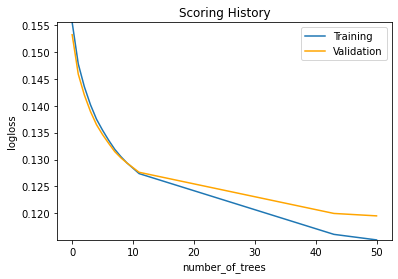

In [10]:
gbm.plot()

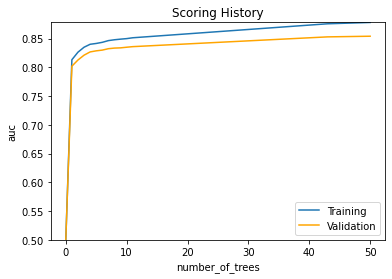

In [11]:
gbm.plot(metric='auc')

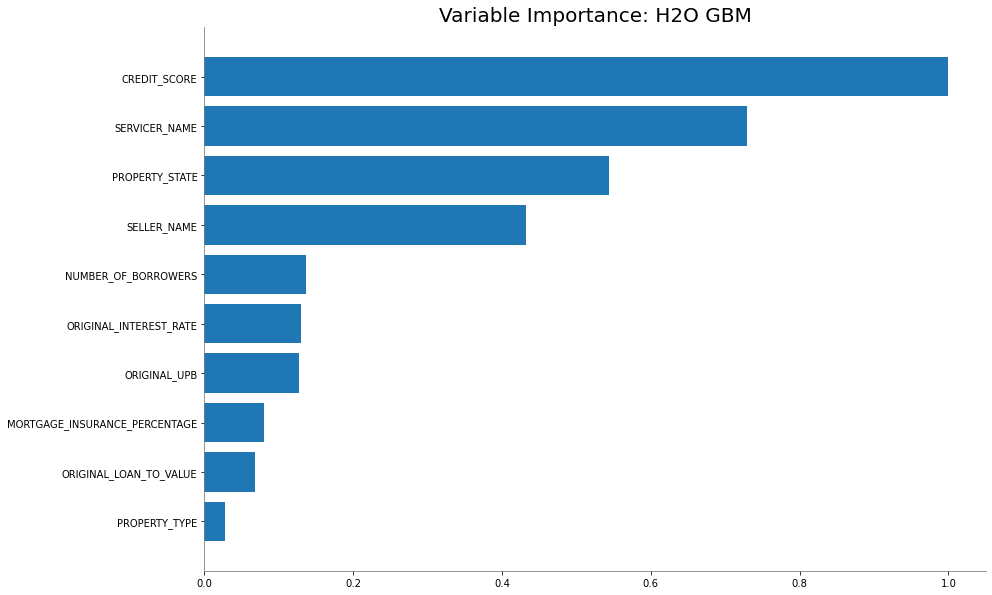

In [13]:
gbm.varimp_plot(10)

### 1.6 Desenvolvimento do Modelo com Grid Search

In [14]:
gbm = H2OGradientBoostingEstimator(
    max_depth=6,
    ntrees=50,
    seed=42,
    model_id='grid_gbm'
    )

hyper_params_tune = {'sample_rate': [x/100. for x in range(20,101)],
                     'col_sample_rate' : [x/100. for x in range(20,101)],
                     'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                     'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                     'learn_rate' : [.5, .25, 0.1, 0.07, 0.05, 0.01, 0.001],
                     'nbins': [2**x for x in range(4,11)],
                     'nbins_cats': [2**x for x in range(4,13)],
                     'min_split_improvement': [0,1e-8,1e-6,1e-4],
                     'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]
                    }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900,  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42 
                       }

random_grid = H2OGridSearch(model=gbm,
                            hyper_params=hyper_params_tune,
                            grid_id='random_grid',
                            search_criteria=search_criteria_tune
                           )

%time random_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 11min 56s


In [15]:
sorted_random_search = random_grid.get_grid(sort_by='f1',decreasing=True)
sorted_random_search.sorted_metric_table()

,,col_sample_rate,col_sample_rate_change_per_level,col_sample_rate_per_tree,histogram_type,learn_rate,min_split_improvement,nbins,nbins_cats,sample_rate,model_ids,f1
0,,0.91,0.9,0.68,QuantilesGlobal,0.1,1.0E-4,16,256,0.55,random_grid_model_7,0.3144306131857999
1,,0.68,0.92,0.59,UniformAdaptive,0.1,1.0E-6,16,128,0.7,random_grid_model_41,0.31242959068719495
2,,0.91,1.05,0.46,QuantilesGlobal,0.07,1.0E-4,1024,1024,0.63,random_grid_model_17,0.30887258172114745
3,,0.58,0.99,0.83,UniformAdaptive,0.1,0.0,32,64,0.6,random_grid_model_65,0.30832759807295246
4,,0.87,0.91,0.62,UniformAdaptive,0.05,1.0E-4,128,128,0.54,random_grid_model_59,0.30823529411764705
...,...,...,...,...,...,...,...,...,...,...,...,...
95,,0.94,1.06,0.81,RoundRobin,0.5,1.0E-8,512,4096,0.41,random_grid_model_98,0.2535917139993318
96,,0.77,0.95,0.26,QuantilesGlobal,0.001,1.0E-4,16,32,0.66,random_grid_model_85,0.25164668130383383
97,,0.44,1.04,0.65,QuantilesGlobal,0.5,0.0,32,1024,0.24,random_grid_model_91,0.2485565026120429
98,,0.61,1.06,1.0,RoundRobin,0.001,1.0E-8,256,16,0.51,random_grid_model_77,0.24472857783759533


### 1.7 Comparação do Modelo Padrão vs. Grid Search

In [20]:
# Avaliar a performance do melhor modelo comparando com o o GLM default
default_gbm_perf=default_gbm.model_performance(test)

tuned_gbm = random_grid.models[0] 
tuned_gbm.summary()
tuned_gbm_perf = tuned_gbm.model_performance(test)

print("Default GBM AUC: %.4f \nTuned GBM AUC:%.4f" % (default_gbm_perf.auc(), tuned_gbm_perf.auc()))

Default GBM AUC: 0.8587 
Tuned GBM AUC:0.8616


In [21]:
default_gbm_perf.F1()

[[0.15548109981154604, 0.30261162594776747]]

In [22]:
print ("Default GBM: ", default_gbm_perf.F1())
print ("Tuned GBM: ",  tuned_gbm_perf.F1())

Default GBM:  [[0.15548109981154604, 0.30261162594776747]]
Tuned GBM:  [[0.13538139855552325, 0.3006555877420338]]


In [23]:
print ("Default GBM: ", default_gbm_perf.confusion_matrix())
print ("Tuned GBM: ",  tuned_gbm_perf.confusion_matrix())

Default GBM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15548109981154604: 


,,FALSE,TRUE,Error,Rate
0,FALSE,69861.0,2365.0,0.0327,(2365.0/72226.0)
1,TRUE,1774.0,898.0,0.6639,(1774.0/2672.0)
2,Total,71635.0,3263.0,0.0553,(4139.0/74898.0)



Tuned GBM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13538139855552325: 


,,FALSE,TRUE,Error,Rate
0,FALSE,69325.0,2901.0,0.0402,(2901.0/72226.0)
1,TRUE,1686.0,986.0,0.631,(1686.0/2672.0)
2,Total,71011.0,3887.0,0.0612,(4587.0/74898.0)


In [24]:
h2o.cluster().shutdown()

H2O session _sid_812c closed.


===============================================================================